In [2]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#https://realpython.com/k-means-clustering-python/
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv(r'.\Data\week7\train.csv')

In [151]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [5]:
#Fill missing values with mean column values in the train set
data.fillna(data.mean(), inplace=True)

C:\Users\rgaud\AppData\Local\Temp/ipykernel_2532/3219067192.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.fillna(data.mean(), inplace=True)


In [6]:
data = data.drop(['Name', 'Ticket', 'Cabin', 'Embarked', 'Fare', 'PassengerId'], axis=1)

In [205]:
features = data.drop(['Survived'], axis=1)
true_labels = data.drop(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], axis=1)

In [208]:
#Convert Sex into numerical value - using Label Encoding
labelEncoder = LabelEncoder()
labelEncoder.fit(features['Sex'])
features['Sex'] = labelEncoder.transform(features['Sex'])

In [209]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [210]:
scaled_features[:5]

array([[ 0.82737724,  0.73769513, -0.5924806 ,  0.43279337, -0.47367361],
       [-1.56610693, -1.35557354,  0.63878901,  0.43279337, -0.47367361],
       [ 0.82737724, -1.35557354, -0.2846632 , -0.4745452 , -0.47367361],
       [-1.56610693, -1.35557354,  0.40792596,  0.43279337, -0.47367361],
       [ 0.82737724,  0.73769513,  0.40792596, -0.4745452 , -0.47367361]])

In [211]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=2, random_state=42)

In [212]:
# The lowest SSE value
kmeans.inertia_

3402.994878872953

In [213]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.0438773 ,  0.12524152,  0.19966918, -0.25269593, -0.37818873],
       [ 0.19596731, -0.55936092, -0.89177401,  1.12860515,  1.6890883 ]])

In [214]:
kmeans.labels_[:5]
#Cluster numbers may be flipped here but that's okay

array([0, 0, 0, 0, 0])

In [215]:
features[:5]

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0
2,3,0,26.0,0,0
3,1,0,35.0,1,0
4,3,1,35.0,0,0


In [216]:
# See how many clusters to do - elbow method
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

C:\Users\rgaud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


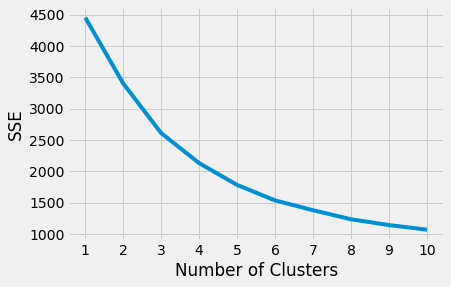

In [217]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [218]:
# Can programatically work out the elbow
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)
kl.elbow

4

In [219]:
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

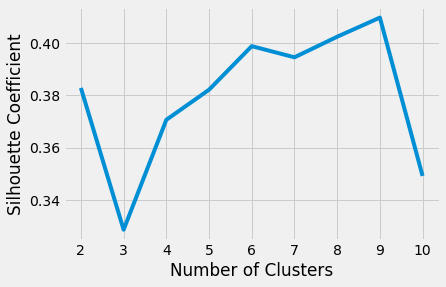

In [220]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [221]:
# Elbow & Silhouette - work when you don't have any "ground truth" labels
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [229]:
# Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=2.4)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   scaled_features, dbscan.labels_
).round (2)

In [230]:
kmeans_silhouette

0.38

In [231]:
dbscan_silhouette

0.51

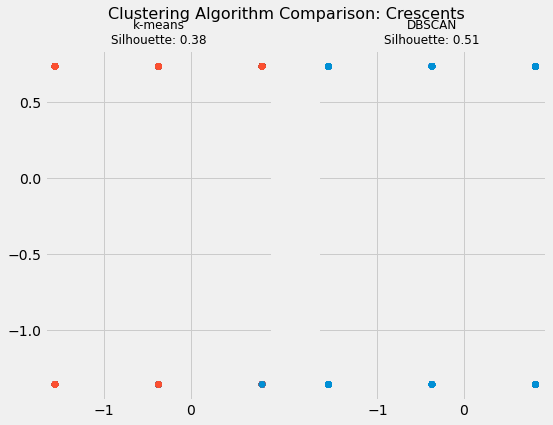

In [232]:
# Plot the data and cluster silhouette comparison
#K-Means gets higher silhouette score - but DBSCAN finds the more natural cluster
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    -1: "#aaaaaa",
    0: "#008fd5",
    1: "#fc4f30",
    2: "#ff8000",
    3: "#ffffff"
}
# The k-means plot
km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12}
)

# The dbscan plot
db_colors = [fte_colors[label] for label in dbscan.labels_]
ax2.scatter(scaled_features[:, 0], scaled_features[:, 1], c=db_colors)
ax2.set_title(
    f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

In [233]:
ari_kmeans = adjusted_rand_score(true_labels.values.flatten(), kmeans.labels_)
ari_dbscan = adjusted_rand_score(true_labels.values.flatten(), dbscan.labels_)

In [234]:
round(ari_kmeans, 2)

0.04

In [235]:
round(ari_dbscan, 2)

-0.01